In [150]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizerFast
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from datasets import load_dataset
import spacy
import seaborn as sns
import time

In [2]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification)

from pytorch_transformers import AdamW, WarmupLinearSchedule 

In [3]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizerFast)
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [4]:
def get_labels_from_label_dict(lbl_dict_path):
        line_id = 0
        labels = []
        for line in open(lbl_dict_path, encoding='utf8'):
            fds = line.strip().split(' ')
            assert len(fds) == 2, 'incorrect format {}'.format(line)
            lbl = fds[0]
            fid = int(fds[1])
            assert fid == line_id, 'id not correct {} -- {}'.format(fid, line_id)
            labels.append(lbl)
            line_id += 1
        return labels

In [5]:
args = {
'data_dir':'C:\\Users\\ryserrao\\Microsoft_work\\AIPLATFORM_SHAP\\PPT_Text_to_Icon_Data\\Turing_Text2Icon_Code_and_Model\\outputs',
'model_name_or_path':'ft_set12_256x2_pcln2sc_nowiki.py_e10_wu02_bs8_ts08_sc12_lr7e-5',
'data_path':'test_mturk.txt',
'task_name':'text2content',
'do_lower_case':True,
'lbl_dict_path' : 'train.txt.lbl.dict.txt',
'max_seq_len':32
}
labels = get_labels_from_label_dict(os.path.join(args['data_dir'], args['lbl_dict_path']))
num_labels = len(labels)

In [6]:
config = config_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), do_lower_case=args['do_lower_case'])
model = model_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']),config=config).cuda()

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text2content",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "num_labels": 865,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler": "cls",
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [7]:
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [8]:
data = nlp.load_dataset('reddit',split='train')

Using custom data configuration default


In [9]:
data

Dataset(features: {'author': Value(dtype='string', id=None), 'body': Value(dtype='string', id=None), 'normalizedBody': Value(dtype='string', id=None), 'subreddit': Value(dtype='string', id=None), 'subreddit_id': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}, num_rows: 3848330)

In [10]:
subreddit = data['subreddit']

#### Unique subreddits

In [11]:
print(f'Total unique subreddits: {len(set(subreddit))}')


Total unique subreddits: 29651


In [158]:
print(list(set(subreddit))[:1000])

['', 'Cadillac', 'Nurse', 'mobas', 'MensRights', 'veg', 'DirtyJokes', 'selfmedicate', 'runescape', 'Redditropolis', 'GoPlus', 'guildrecruitment', 'G502MasterRace', 'symfony', 'ledzeppelin', 'taxi', 'TridentLayers', 'RandomActsOfDota', 'JackyDee', 'circlebroken', 'motiongraphics', 'peloton', 'droiddna', 'TheRecordCorrected', 'Colts', 'AnotherFnafShitPosts', 'psytrance', 'badhistoryrebooted', 'dyscultured', 'Storytelling', 'progressive_islam', 'OMSCS', 'byzantium', 'winemaking', 'anunturi', 'FIU', 'EducatedCollins', 'Somerville', 'USCivilWar', 'tifu', 'Abilene', 'GunnersFCR', 'HalifaxR4R', 'OrbitalGear', 'DotaCR', 'AndrewWK', 'IamNumberFour', 'IAmA_ja', '28thAmendment', 'MetaEH', 'modelrailroads', 'college', 'Lompton', 'WarTortoise', 'ChildrenFallingOver', 'QualityNsfw', 'ProjectRunway', 'EnoughPaulSpam', 'camming', 'france', 'billiards', 'ing', 'StarWars', 'Bondage', 'EQUIPnTRIP', 'VictoryMotorcycles', 'CollectiveIntelGroup', 'dominicans', 'music_buffalo', 'Celticheroes', 'Piss', 'Legal

In [19]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [20]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [181]:
start = time.process_time()
shap_values_multiclass = explainer(data['summary'][:1000])
print(f'Total time of execution: {time.process_time() - start}')

Partition explainer: 1001it [01:32, 10.80it/s]                          
Total time of execution: 111.859375


In [22]:
data['summary'][:10]

['Shifting seasonal time is no longer worth it.',
 "Personal opinions 'n shit.",
 "insults and slack ass insight. \n Wall Street Journal misses on enough counts that not only did i yawn with boredom, i fell asleep trying to read through this crap. \n It may be the paper for you, but if your in the the market for a new read, i'd at least counsel you on reading the Washington Post instead, due out on stands anytime, or the Globe, which is slated for a weekly release.",
 'Yes, Joysticks in modern games have apparently become passe unless you are playing a flight sim and that sucks.',
 'Class only items dropped from high-lvl monsters.',
 'OPI Nail Envy!',
 "I don't drive like  most  people in major cities, and need public transit directions integrated in iOS6 Maps.",
 "you don't seem to understand what's going on here.",
 'How we make money? How we involve everyone, yo?',
 "I'll try and get some similar shots from lake Kaweah next time I'm up there because there is an entire small town und

In [154]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

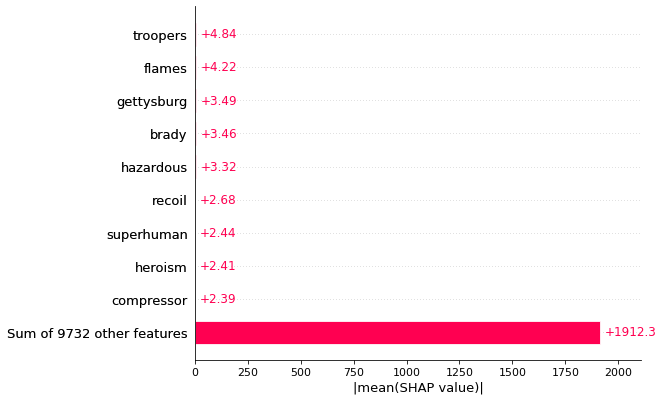

In [155]:
label='__label__Fire'
custom_masked_bar_plot(label2id[label],'pos','mean')

#### Semantic grouping of words

In [160]:
import heapq as pq
nlp = spacy.load("en_vectors_web_lg")

In [161]:
def semantic_grouping(semantic_groups_ll,sentences,topk=10):
    for group in semantic_groups_ll:
        semantic_groups_dict[group]={'similar_words':[],'unique_words':set(),'token_spacy':nlp(group)}
    for sentence in sentences:
        tokens = nlp(sentence)
        for token in tokens:
            for group in semantic_groups_ll:
                if token.text not in semantic_groups_dict[group]['unique_words']:
                    if len(semantic_groups_dict[group]['unique_words'])<topk:
                        pq.heappush(semantic_groups_dict[group]['similar_words'],(semantic_groups_dict[group]['token_spacy'].similarity(token),token.text))
                        semantic_groups_dict[group]['unique_words'].add(token.text)
                    else:
                        sim_score, text = pq.heappop(semantic_groups_dict[group]['similar_words'])
                        semantic_groups_dict[group]['unique_words'].remove(text)
                        new_sim_score = semantic_groups_dict[group]['token_spacy'].similarity(token)
                        if new_sim_score>sim_score:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(new_sim_score,token.text))
                            semantic_groups_dict[group]['unique_words'].add(token.text)
                        else:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(sim_score,text))
                            semantic_groups_dict[group]['unique_words'].add(text)

In [223]:
semantic_groups_ll = ['politics','entertainment','violence','racism','gender','terrorism','racist','offensive']
semantic_groups_dict={}
semantic_grouping(semantic_groups_ll, data['summary'][:1000], topk=10)

In [224]:
def extract_similar_words(group):
    sem_group = []
    for _, g in sorted(semantic_groups_dict[group]['similar_words'],reverse=True):
        sem_group.append(g)
    return sem_group

In [225]:
for group in semantic_groups_ll:
    print(f'Semantic group: {group}')
    print(f'Words: {",".join(extract_similar_words(group))} \n')

Semantic group: politics
Words: political,debate,religion,society,economics,politically,racism,social,politician,culture 

Semantic group: entertainment
Words: entertainment,entertaining,gaming,sports,recreation,music,tv,TV,enjoyment,arts 

Semantic group: violence
Words: violent,abuse,racism,rape,intimidation,suicide,oppression,gangs,fear,justice 

Semantic group: racism
Words: racism,oppression,ignorance,homophobic,sexist,hate,HATE,racially,intimidation,religion 

Semantic group: gender
Words: Gender,gender,sexes,identity,women,Women,social,female,perceived,racism 

Semantic group: terrorism
Words: terrorists,war,attacks,political,criminal,racism,conspiracy,violent,suicide,justified 

Semantic group: racist
Words: homophobic,sexist,racism,ignorant,insulting,racially,stupid,moron,Moron,idiot 

Semantic group: offensive
Words: offensive,defensive,atrocious,attack,worst,insulting,terrible,teammates,ridiculous,drafted 

Semantic group: slave
Words: submissive,humiliation,fetish,slut,puni

#### Cumulative Shap values

In [226]:
def get_cumulative_shap_values_abs_mean(word_set,shap_values):
    token_list = shap_values.abs.mean(0).feature_names.tolist()
    shap_values_abs_mean = shap_values.abs.mean(0)
    shap_values_list = []
    for word in word_set:
        if word in token_list:
            shap_values_word = shap_values_abs_mean.values[token_list.index(word)]
            shap_values_list.append(shap_values_word)
    
    if shap_values_list:
        return np.array(shap_values_list).mean(0)
    else:
        return np.zeros(shap_values.base_values[0].shape)

In [166]:
def get_cumulative_shap_values_abs_per_sample_mean(word_set,shap_values, aggregate_shap_values = 'mean'):
    num_samples = shap_values.values.shape[0]
    shap_values_full_set = []
    
    for word in word_set:
        shap_values_word_set = []
        for index in range(num_samples): 
            token_list = shap_values[index:index+1].abs.mean(0).feature_names.tolist()
            if word in token_list:
                shap_values_abs_mean = shap_values[index:index+1].abs.mean(0)
                shap_values_list = []
                shap_values_word = shap_values_abs_mean.values[token_list.index(word)]
                shap_values_list.append(shap_values_word)
                if shap_values_list:
                    shap_values_word_set.append(np.array(shap_values_list).mean(0))
        
        if shap_values_word_set:
            shap_values_full_set.append(np.sum(np.array(shap_values_word_set),axis=0)/num_samples)
    
    if shap_values_full_set:
        if aggregate_shap_values == 'sum':
            return np.sum(np.array(shap_values_full_set),axis=0)
        elif aggregate_shap_values == 'mean':
            return np.array(shap_values_full_set).mean(0)
    else:
        return np.zeros(shap_values.base_values[0].shape)

In [167]:
def get_cumulative_shap_values_normalized(word_set,shap_values, aggregate_shap_values = 'mean'):
    num_samples = shap_values.values.shape[0]
    shap_values_full_set = []
    
    for word in word_set:
        shap_values_word_set = []
        for index in range(num_samples):
            token_list = [token.strip() for token in shap_values[index].data]
            if word in token_list:
                total_shap_values = np.sum(shap_values[index].abs.values,axis=0)
                normalized_values = np.divide(np.array(shap_values[index].abs.values),np.array(total_shap_values))
                shap_values_word = [normalized_values[sample_word_index] for sample_word_index,sample_word in enumerate(token_list) if word == sample_word.strip()]
                if shap_values_word:
                    shap_values_word_set.append(np.array(shap_values_word).mean(0))
        
        if shap_values_word_set:
            shap_values_full_set.append(np.array(shap_values_word_set).mean(0))
    
    if shap_values_full_set:
        if aggregate_shap_values == 'sum':
            return np.sum(np.array(shap_values_full_set),axis=0)
        elif aggregate_shap_values == 'mean':
            return np.array(shap_values_full_set).mean(0)
    else:
        return np.zeros(shap_values.base_values[0].shape)

#### Top icons affected by a semantic group

In [229]:
def plot_top_icons_for_semantic_group(group,shap_values,topk=10):
    if isinstance(group,str):
        risk = get_cumulative_shap_values_abs_mean(extract_similar_words(group),shap_values)
    else:
        risk = get_cumulative_shap_values_abs_mean(group,shap_values)
    df = pd.DataFrame({'Icons':labels,'Risk':risk})
    topk_df=df.sort_values(by = 'Risk', ascending = False)[:topk]
    ax = sns.barplot(x="Risk", y="Icons", data=topk_df,color="royalblue")
    ax.set_title(f'Top icons affected by semantic group: {group}')
    plt.show()

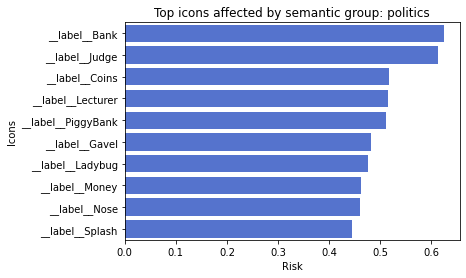

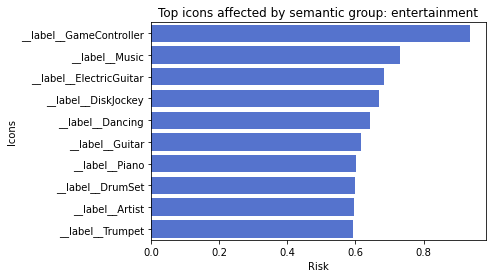

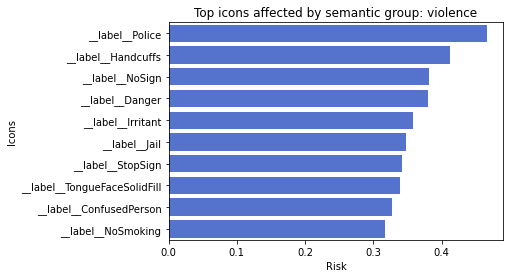

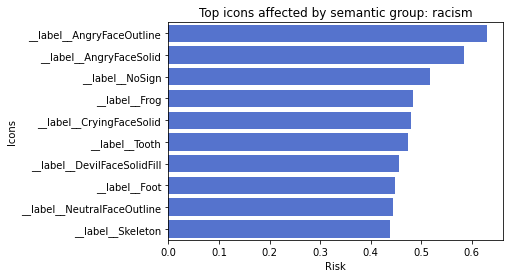

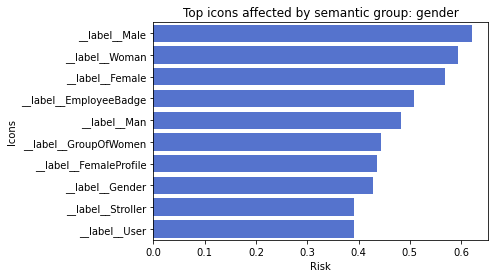

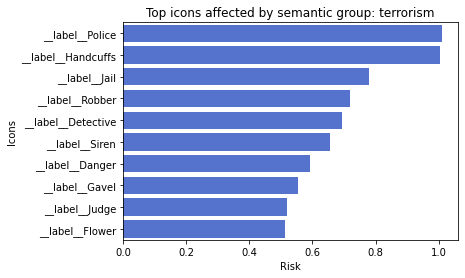

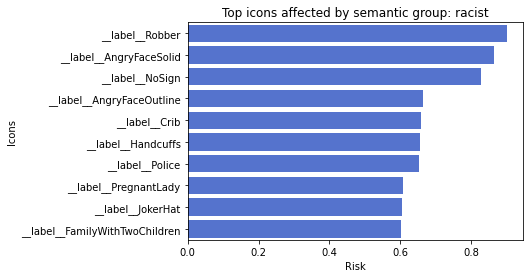

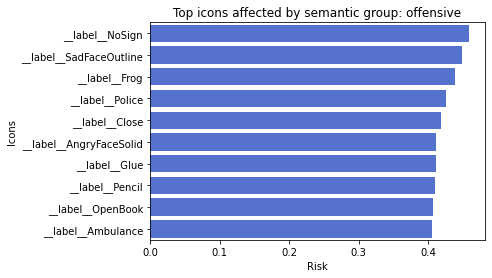

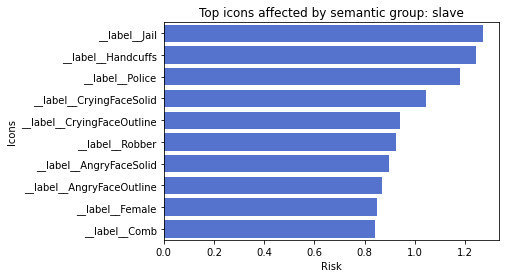

In [230]:
for group in semantic_groups_ll:
    plot_top_icons_for_semantic_group(group,shap_values_multiclass,topk=10)